## Introduction

A surprisingly wide variety of interesting-looking vector line graphics can be generated with a fairly simple technique.

First, we take a bunch of lines. These lines work best if they represent a pattern with some regularity, so I call them the **texture**. Then, we pick a **surface**, which is essentially an elevation map represented by a matrix of heights. It can be generated mathematically or taken from real data. Next, we **map** the texture onto the surface, and capture the heights along all each line to add a third dimension to those lines. Finally, **project** the result to convert the 3D lines back into 2D lines. If we're lucky, these lines will be more interesting to look at than the texture we started with.

We'll use [penkit](https://github.com/paulgb/penkit/)'s `show_layer` function for displaying plots within the notebook, so if the following code throws an `ImportError`, try running `pip install penkit` in a terminal.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from penkit.preview import show_layer
import numpy as np

## Generating a Texture

Let's begin by generating a texture. As I mentioned, a texture is just a set of lines. 

For the first texture we'll take inspiration from the band Joy Division's famous [Unknown Pleasures album cover](https://en.wikipedia.org/wiki/Unknown_Pleasures#/media/File:Unknown_Pleasures_Joy_Division_LP_sleeve.jpg). Joy Division-inspired plots have become a genre in their own right, [sometimes called joy plots](https://twitter.com/JennyBryan/status/856674638981550080)

The texture in this case is simply a bunch of evenly-spaced horizontal lines. To simplify the math later on, it is helpful to constrain texture coordinates such that both dimensions are in the range `[0, 1]`. If you try generating your own (and I encourage you to!), make sure they are within this area (you might find [`penkit.textures.util.fit_texture`](http://penkit.readthedocs.io/en/latest/penkit.textures.html#penkit.textures.util.fit_texture) helpful).

In [2]:
def make_joy_texture(num_lines=10, resolution=50):
    # np.meshgrid is a handy way to generate a grid of points. It
    # returns a pair of matrices, which we will flatten into arrays.
    # For the x-coordinates, we put a nan value at the end so that when
    # we flatten them there is a separater between each horizontal line.
    x, y = np.meshgrid(
        np.hstack([np.linspace(0, 1, resolution), np.nan]),
        np.linspace(0, 1, num_lines),
    )
    
    # For coordinates where the x value is nan, set the y value to nan
    # as well. nan coordinates represent breaks in the path, indicating
    # here that the pen should be raised between each horizontal line.
    y[np.isnan(x)] = np.nan
    return x.flatten(), y.flatten()

Note that we represent all of the lines in two same-sized arrays: one of x-coordinates, and one of y-coordinates. Each coordinate pair creates a line from the previous coordinate pair, unless either contains a `nan` ("not a number") indicator, which represents a gap in the path. All coordinates are absolute, i.e. vectors from the origin rather than relative to the previous point. If you would like a more gradual introduction to this way of representing lines, see my [Fractal Generation with L-Systems](https://bitaesthetics.com/posts/fractal-generation-with-l-systems.html) tutorial.

In [3]:
joy_texture = make_joy_texture(6)

We can use `show_layer` to preview the texture:

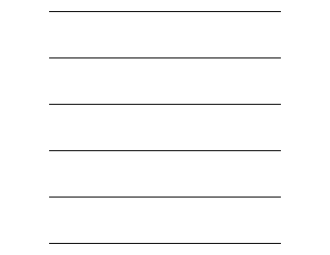

In [4]:
show_layer(joy_texture)

If you count the lines, there are six of them, which is the parameter we passed as `num_lines`. You might have also noticed the optional `resolution` parameter and wondered why it matters. The lines above are actually made up of a bunch of line segments, and the number of these segments is the **resolution**. We can use `matplotlib` to make it clear where the line segments are.

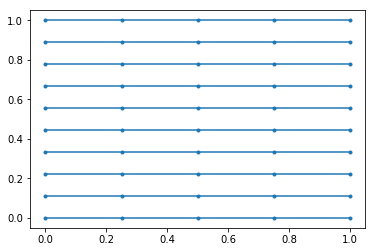

In [5]:
plt.plot(*make_joy_texture(10, 5), marker='.');

Try modifying the parameters to `make_joy_texture` to check your understanding. The resolution doesn't make a difference when we plot the texture, but soon we will be bending the texture into curves. The higher the resolution, the more accurate the curves will be.

## Generating Surfaces

### Blurred Noise Surface

A surface is essentially just a matrix of numbers that we can interpret as elevations. One way to generate interesting surfaces is to generate random noise and blur it.

In [6]:
from scipy.ndimage.filters import gaussian_filter

# This step isn't necessary, but it ensures that the same "random" plot
# will be generated every time the tutorial is run.
np.random.seed(int('banana', 36))

NOISE_BLUR = 40
noise_surface = gaussian_filter(np.random.normal(size=(500, 500)), NOISE_BLUR)

Surfaces can also be visualized with `matplotlib`, but we need to use `imshow` rather than `plot`. Lighter pixels represent points with higher elevations.

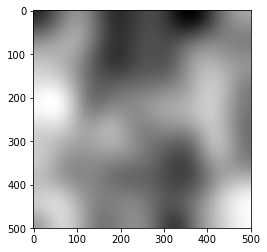

In [7]:
plt.imshow(noise_surface, cmap='gray');

### "Hole" Surface

Another way to generate a surface is to run a mathematical function over the x and y coordinates. To do this easily in `numpy`, we can generate a pair of matrices:

In [8]:
SURFACE_SIZE = 500
grid = np.meshgrid(
    np.linspace(0, 1, SURFACE_SIZE),
    np.linspace(0, 1, SURFACE_SIZE)
)

These matrices represent smooth gradients along the horizontal and vertical axes, respectively. These will be the "raw ingredients" to our process. We can apply different functions to them to get different effects.

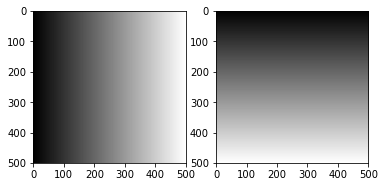

In [9]:
_, (p1, p2) = plt.subplots(1, 2)
p1.imshow(grid[0], cmap='gray')
p2.imshow(grid[1], cmap='gray');

Standard graphing functions, like `sin`, can be generalized into 3D by converting the (x, y) values into a scalar and calling `sin()` on *that*. The natural transformation into a scalar is the *norm*, i.e. the distance from the origin.

Note that the x and y values are scaled between 0 and 1, rather than being the raw pixel coordinates.

In [10]:
hole_surface = np.sin(
    np.linalg.norm((np.array(grid) - 0.5) * np.pi, axis=0))

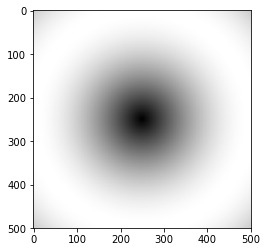

In [11]:
plt.imshow(hole_surface, cmap='gray');

### Bubble Surface

Another fun math function involves taking the product of the sine of both axis. It comes out looking like a grid of bubbles, so I call it the `bubble_surface`.

In [12]:
NUM_BUBBLES_PER_SIDE = 3
bubble_surface = (
    np.sin((grid[0] - 0.5) * NUM_BUBBLES_PER_SIDE * np.pi) *
    np.sin((grid[1] - 0.5) * NUM_BUBBLES_PER_SIDE * np.pi))

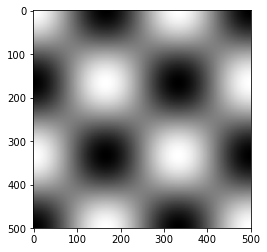

In [13]:
plt.imshow(bubble_surface, cmap='gray');

## Applying the Texture

Now that we have a surface, we can **map** it to the texture. First we strech the texture over the surface dimensions. Then, for each point in the texture, we find its associated pixel on the surface and look up the "elevation" at that point. That elevation becomes the Z-value for the texture. We can think of these Z-values, combined with the original X and Y values, as making up a 3D version of the original texture.

In [14]:
def texture_map(texture, surface):
    texture_x, texture_y = texture
    surface_w, surface_h = surface.shape
    
    # First, we convert the points along the texture into integers within
    # the bounds of the surface's index. The clipping here will also convert
    # the nan values to 0.
    index_x = np.clip(np.int32(surface_w * texture_x), 0, surface_w - 1)
    index_y = np.clip(np.int32(surface_h * texture_y), 0, surface_h - 1)
    
    # Grab z-values along the texture path. Note that this will include values
    # for every point, even if it is nan or had to be clipped to within the
    # bounds of the surface, so we have to fix that next.
    surface_z = surface[index_x, index_y]
    
    # Set z-values that are either out of bounds or nan in the texture to nan
    # in the output.
    # Numpy wants to warn about the fact that there are nan values in the
    # textures, so we silence warnings about this.
    with np.errstate(invalid='ignore'):
        surface_z[(texture_x < 0) | (texture_x >= 1) |
                  (texture_y < 0) | (texture_y >= 1)] = np.nan
    
    return surface_z

To actually plot this 3D shape, we need to **project** it back to 2D. There are different ways to do this, but one way is to preserve the X coordinates, and use a linear blend of the Y and Z coordinates as the Y coordinates. Here's a function that handles both the **mapping** (by calling `texture_map`) and **projection**.

In [15]:
def texture_plot(texture, surface, angle=45, **kwargs):
    # Extract the Xs and Ys from the texture
    surface_x, surface_y = texture
    
    # Map the texture to get the Zs
    surface_z = texture_map(texture, surface.T)
    
    # The projection is as simple as linearly blending the Z and Y
    # dimensions. The multiples are calculated from the given
    # angle with standard trig.
    z_coef = np.sin(np.radians(angle))
    y_coef = np.cos(np.radians(angle))
    plot = (surface_x, -surface_y * y_coef + surface_z * z_coef)

    return show_layer(plot, **kwargs)

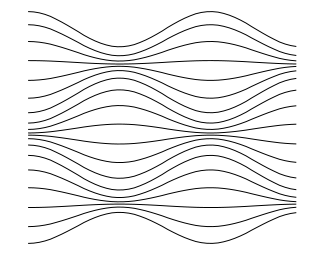

In [16]:
texture_plot(make_joy_texture(20), bubble_surface * 0.1, 40)

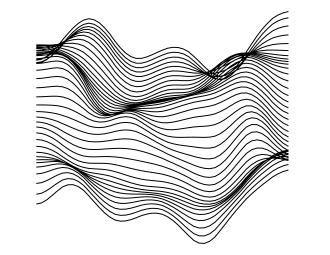

In [17]:
texture_plot(make_joy_texture(40), noise_surface * 12, 40)

In both examples above, I've applied a scale to the surface by multiplying a number to the surface. Try modifying the multipliers and see what happens. Also, try modifying the angle parameter to other numbers between 0 and 90.

## Dark Side of the Surface

You may have noticed that in the plot above, some of the lines cross each other. This gives the impression that the surface is transparent, as if we can "see through" it to lines behind the surface. In order to make images that look 3D, we can make the surface appear opaque by not drawing lines that would be obscured by the surface.

One way to do this is by "masking" the visible parts of the surface. First, we apply the projection to the surface. Then, we walk over the surface keeping track of the maximum height as we go. Only the parts of the surface where the height of the sloped surface is equal to the (cumulative) maximum are kept.

To understand this, consider a two-dimensional version below. The lines of sight are parallel, because we are using an [axonometric projection](https://en.wikipedia.org/wiki/Axonometric_projection). In this example, the lighter-colored parts of the surface would be masked out because they are hidden to the observer. If you trace the line left to right, you can see that points along the line are only visible if no point left of them is higher. In other words, they are equal to the cumulative maximum point.

![](https://bitaesthetics.com/img/eye.svg)

The same principle applies for our surfaces, but we have to do it for every cross-section of the surface. Fortunately, `matplotlib` has a function `np.maximum.accumulate` that calculates a cumulative maximum over every slice at once. By comparing the cumulative maximums to the actual elevation, we can determine the visibility of each pixel on the surface. The result of this function is a [mask](https://en.wikipedia.org/wiki/Mask_%28computing%29) that tells us which pixels of the surface are visible.

In [18]:
def make_visible_mask(surface, angle):
    s = surface.shape[0]
    
    # Just as in projection, we calculate the Y and Z
    # coefficients with sin/cos.
    y_coef = np.cos(np.radians(angle))
    z_coef = np.sin(np.radians(angle))
    
    # Rotate the surface so that the visibilty mask represents
    # the visibility at the desired angle.
    projected_surface = (
        z_coef * surface -
        y_coef * np.expand_dims(np.linspace(0., 1., s), axis=1)
    )
    
    # Calculate the cumulative maximum along each cross-section of
    # the projected surface. We flip on the input and output because
    # we want to accumulate from the bottom of the surface up, rather
    # than the top-down. This is because we interpret the bottom of
    # the surface as closer to the observer.
    projected_surface_max = np.flipud(np.maximum.accumulate(np.flipud(projected_surface)))
    
    # Compare each point on the surface to the cumulative maximum
    # along its cross-section.
    return projected_surface == projected_surface_max

To apply the mask, we can set all values of the surface that are *not* in the mask to `nan`.

In [19]:
def remove_hidden_parts(surface, angle):
    surface = np.copy(surface)
    surface[~make_visible_mask(surface, angle)] = np.nan
    return surface

The input and output of this process, as well as the mask used, are shown below.

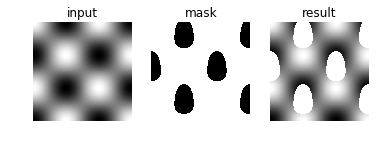

In [20]:
_, (i, m, r) = plt.subplots(1, 3)
# Plot input surface
i.imshow(bubble_surface, cmap='gray')
i.set_title('input')
i.axis('off')
# Plot mask
m.imshow(make_visible_mask(bubble_surface, 10), cmap='gray')
m.set_title('mask')
m.axis('off')
# Plot result
r.imshow(remove_hidden_parts(bubble_surface, 10), cmap='gray')
r.set_title('result')
r.axis('off');

Putting it all together, we can apply `remove_hidden_parts` to a surface and get the result we want.

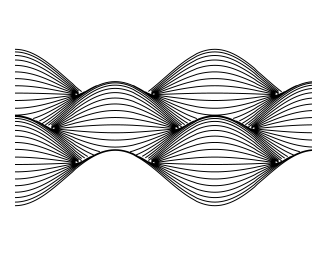

In [21]:
angle=70
texture_plot(make_joy_texture(50, 100), remove_hidden_parts(bubble_surface * 0.1, angle), angle)

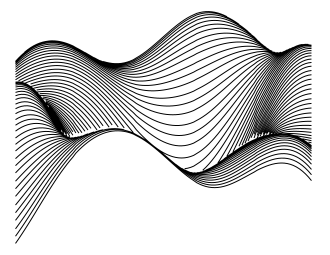

In [22]:
angle=65
texture_plot(make_joy_texture(80, 100), remove_hidden_parts(
    hole_surface * 1.2 + noise_surface + bubble_surface * 0.1, angle), angle)

## Grids

Now that we have seen how projection works, let's explore some more interesting textures. If we swap the X and Y dimensions, our horizontal lines become vertical lines. By concatenating the vertical and horizontal lines, we can make a grid texture.

In [23]:
def make_grid_texture(num_h_lines=10, num_v_lines=10, resolution=50):
    x_h, y_h = make_joy_texture(num_h_lines, resolution)
    y_v, x_v = make_joy_texture(num_v_lines, resolution)
    return np.concatenate([x_h, x_v]), np.concatenate([y_h, y_v])

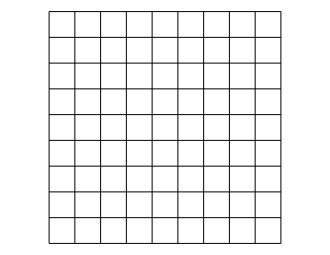

In [24]:
show_layer(make_grid_texture())

Let's use `penkit`'s `rotate_texture` function to play with the grid.

In [25]:
from penkit.textures.util import rotate_texture, fit_texture
grid_texture = fit_texture(rotate_texture(make_grid_texture(40, 40, 200), 40))

Just as we scaled surfaces before by multiplying them by a scale factor, we can combine them by adding them. Let's combine all of the surfaces we've seen and map a grid texture to them. Try changing some of the values and seeing how the plot changes.

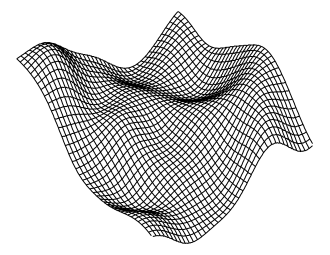

In [26]:
angle = 30
texture_plot(grid_texture, remove_hidden_parts(
    0.1 * hole_surface + 16 * noise_surface + 0.1 * bubble_surface, angle), angle)

## More Textures

Penkit includes some additional textures we can play with. Here's a way to create a spiral.

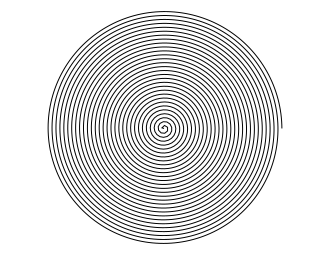

In [27]:
from penkit.textures import make_hex_texture, make_spiral_texture
spiral_texture = make_spiral_texture(
    spirals=30,     # how many full rotations to do
    ccw=False,      # whether to go counter-clockwise
    resolution=3000 # resolution (how many lines to use)
)
show_layer(spiral_texture)

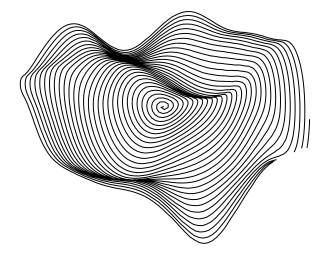

In [28]:
angle = 45
texture_plot(spiral_texture, remove_hidden_parts(
    0.1 * bubble_surface + 6 * noise_surface, angle), angle)

Another texture provided by penkit is a hexagonal grid.

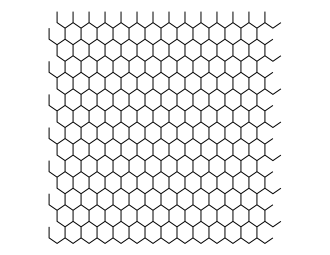

In [29]:
from penkit.textures import make_hex_texture
show_layer(make_hex_texture(14, 10))

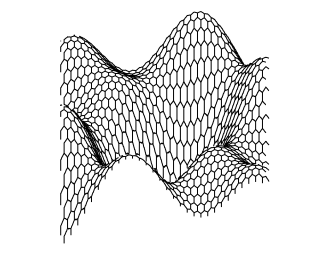

In [30]:
angle = 45
texture_plot(make_hex_texture(30, 10), remove_hidden_parts(
    hole_surface + 0.2 * bubble_surface, angle), angle)

## Topographic Data

Instead of generating the surface, as we have done so far, we can instead use real data as a source for the surface. In the United States, the [U.S. Geological Survey](https://nationalmap.gov/elevation.html) provides topographic data for free. Numpy can't read the files directly, so I've pre-prepared a numpy object file derived from the data.

Here's a surface generated from the topography of San Francisco.

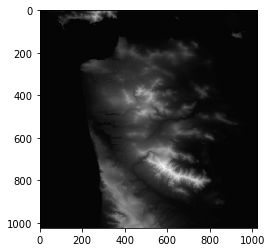

In [31]:
sf_surface = np.load('sf.npy')
plt.imshow(sf_surface, cmap='gray');

Since texture mapping takes just one pixel for each point in the texture, it is sensitive to noise and other high-frequency changes in the data. One way to solve this would be to modify the texture mapping function to sample more points on the surface around the target. Equivalently, we could just modify each point on the surface to represent a sample of the pixels that surround it. That's exactly what `gaussian_filter`, which we've already used for the `noise_surface`, does: it takes a weighted sample of the pixels around each pixel, and gives us a new surface.

I've also log-transformed the data. This emphasizes relative differences in height over absolute differences. Depending on the data I find it can lead to better results.

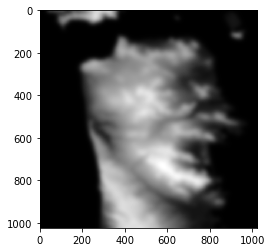

In [32]:
sf_surface = np.float32(sf_surface)
sf_surface = gaussian_filter(np.log(sf_surface+1.), 10)
plt.imshow(sf_surface, cmap='gray');

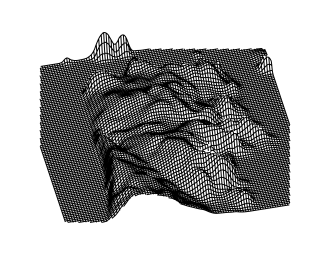

In [33]:
angle = 46
texture_plot(rotate_texture(make_grid_texture(100, 100, 200), 13), remove_hidden_parts(
        sf_surface / 20, angle), angle)

## Hilbert Curves

Let's explore one more texture I find interesting. Penkit includes tools for plotting [L-Systems](https://bitaesthetics.com/posts/fractal-generation-with-l-systems.html). These can make interesting textures for surface projection. One example is the [Hilbert curve](https://en.wikipedia.org/wiki/Hilbert_curve).

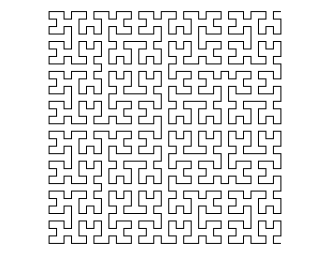

In [34]:
from penkit.fractal import hilbert_curve
show_layer(hilbert_curve(5))

To make this into a texture suitable for surface projection, we can use `fit_texture`. If we want to apply a rotation, we can do so before the call to `fit_texture` (try reversing the order for a different effect.)

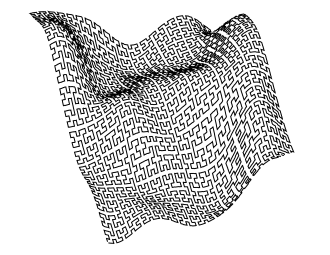

In [35]:
hilbert_texture = fit_texture(rotate_texture(hilbert_curve(6, 5), 22))
angle = 6
texture_plot(hilbert_texture, remove_hidden_parts(noise_surface * 81, angle), angle)

## Next Steps

- Try creating your own surfaces and textures.
- Use `penkit.write.write_plot` to save your plot as an `svg` suitable for plotting.
- Look into [GDAL](http://www.gdal.org/) for converting topographic data into numpy arrays